# SPAM EMAIL CLASSIFIER

DATE: 29-08-2022

## PROBLEM STATEMENT

Due to the rising rate at which people get scammed through emailing messges, this project tends to build a model that predicts whether an incoming message is a scam or not. 

### FILES

There are ham enails 2551  and 501 spam emails in the dataset

- **Source**: https://www.kaggle.com/veleon/ham-and-spam-dataset

### Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import os
import email
import email.policy
import random
import matplotlib.pyplot as plt

In [2]:
#get spam and ham emails data
PATH = r'C:\Users\Oluwatimilehin F\Documents\Data SC\ZUMMIT\hamnspam\'
ham_filenames = [name for name in os.listdir(PATH+'ham')]
spam_filenames = [name for name in os.listdir(PATH+'spam')]
random.shuffle(ham_filenames)  #shuffle first
random.shuffle(spam_filenames)

In [3]:
#load emails
def load_email(is_spam,filename,path):
    '''
    Load email by its name and location
    
    @is_spam: whether email is spam or not
    @filename: email name
    @path: PATH 
    
    @return: email object
    '''
    if is_spam :
        path = path + 'spam/' + filename
    else :
        path = path + 'ham/' + filename
    with open(path,'rb') as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)

ham_emails = [load_email(False,name,PATH) for name in ham_filenames]
spam_emails = [load_email(True,name,PATH) for name in spam_filenames]

#remove not text type emails
ham_emails = [email for email in ham_emails if type(email.get_payload()) is str or len(email.get_payload())>1] 
spam_emails = [email for email in spam_emails if type(email.get_payload()) is str or len(email.get_payload())>1]

print('Number of spam emails:',len(spam_emails))
print('Number of ham emails:',len(ham_emails))

Number of spam emails: 458
Number of ham emails: 2548


Thsi implies that there are about 3 empty files in the ham dataset and 43 empty files in the spam dataset

In [4]:
#example
test_email = spam_emails[0]
print('Example spam email content:\n\n',test_email.get_payload()) 

Example spam email content:

 NEW - NEW - NEW   IN THE MARKET
JUST RELEASED:
 
300 Million email addresses--Database Fully Exportable, On 3 CDs!!

300 Million email addresses--Database Fully Exportable, On 3 CDs!! =Only $99.95
** Contains US & International EMAILS ** 
With 1.5 Million USA Business Fully Exportable Fax Numbers,   

ALL TWO DIRECTORIES ABOVE (300 Million and faxes #)	 ** ONLY $99.95 **

BOTH EMAIL DIRECTORIES ARE CATEGORIZED
Email Address CDROM (300 Million Addresses)
MORE THAN 134 CATEGORIES SUCH AS:

USA--50 STATES AND AREA CODE:
Contains e-mail addresses of people living in all 50 states. Each state is broken down by area codes. 

Canada and Area Code:
Contains e-mail addresses of people living in Canada. Each province is
broken down by area codes

Adult:
Contains e-mail addresses of people interested in adult content

Auto:
Contains e-mail addresses of people interested in automotive content

Canada:
Contains e-mail addresses of people living in Canada. Each province

In [5]:
#stem words
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
ps = PorterStemmer()

[nltk_data] Downloading package punkt to C:\Users\Oluwatimilehin
[nltk_data]     F\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
#process email's content
import re
import string
def process_email(content) :
    '''
    preprocesses the content of an email 
    
    and returns a dictionary with word as key and its frequency as value
    @content : email content (a string)
    @return : a counting dictionary 
    '''                                         
    if not isinstance(content,str) :       
        return {},''
    content = re.sub(r'<[^<>]+>', ' ',content)  ##strip all HTML
    content = str.lower(content) ##lower case
    
    #handle URLS with http:// or https://
    content = re.sub(r'(http|https)://[^\s]*','httpaddr ',content) 
    
    #handle email addresses
    #look for strings with @ in the middle
    content = re.sub(r'[^\s]+@[^\s]+','emailaddr',content)
    
    content = re.sub(r'[0-9]+', 'number ',content) #handle numbers
    content = re.sub(r'[$]+','dollar ',content) #handle $ sign 
    content = re.sub(r'[\n]+',' ',content) #remove \n
    #remove punctuaion
    content = re.sub(r'[{0}]'.format(string.punctuation),' ',content) 
    
    res = {}
    words = word_tokenize(content)
    content = ' '.join([ps.stem(word) for word in words])
    for word in words :
        word = ps.stem(word)
        if len(word) > 11 :
            continue
        if len(word) <=1 :
            continue
        if not res.get(word):
            res[word] = 0
        res[word] += 1
    
    return res,content

In [7]:
(res,content) = process_email(test_email.get_payload())
print('Email content becomes:\n\n',process_email(test_email.get_payload())[1]) 
print('\n')

Email content becomes:

 new new new in the market just releas number million email address databas fulli export on number cd number million email address databas fulli export on number cd onli dollar number number contain us intern email with number number million usa busi fulli export fax number all two directori abov number million and fax onli dollar number number both email directori are categor email address cdrom number million address more than number categori such as usa number state and area code contain e mail address of peopl live in all number state each state is broken down by area code canada and area code contain e mail address of peopl live in canada each provinc is broken down by area code adult contain e mail address of peopl interest in adult content auto contain e mail address of peopl interest in automot content canada contain e mail address of peopl live in canada each provinc is broken down by area code classifi contain e mail address of peopl advertis in classi

In [8]:
#build vocabulary for spam emails
def build_vocab(emails) :
    '''
    build_vocab will build a vocabulary with words 
    appearing in the email content
    @emails : list of email
    @return : 
    '''
    assert isinstance(emails,list)
    dic = {}
    index = 0
    
    while index < len(emails) :
        email = emails[index]
        judge = email.get_payload()
        if type(judge) is not str:
            dict_email = {}
            for e in judge :
                dic_toadd = process_email(e.get_payload())
                for word in dic_toadd[0] :
                    if not dic_email.get(word):
                        dic_email[word] = 0
                    dic_email[word] += 1
        else :
            dic_email = process_email(judge)[0]
        for word in dic_email.keys() :
            if not dic.get(word) :
                dic[word] = 0
            dic[word] += dic_email[word]
        index+=1
    
    return dic
# print(test_email['Subject'])
vocab = build_vocab(spam_emails)
print('number of total words in spam emails:', len(vocab.keys()))
vocab = [word for word in vocab.keys() if vocab[word]>11]
print('number of words that with frequency than 11:', len(vocab))
n = len(vocab)

number of total words in spam emails: 44304
number of words that with frequency than 11: 1772


In [9]:
#export vocabulary to a csv file
df_vo = pd.DataFrame(vocab)
df_vo = df_vo.rename(columns={0:'words'})
df_vo.to_csv('vocabulary.csv',index=False)

In [10]:
import random
class emailToFeature:
    '''
    This is a class for building feature vectors
    '''
    def __init__(self,filename) :
        vocab = pd.read_csv(filename)
        vocab = list(vocab['words'])
        index = 0
        vocabulary = {}
        while index < len(vocab) :
            vocabulary[vocab[index]] = index
            index+=1
        self.d = len(vocab)
        self.vocab = vocabulary   
    
    def fea_vector(self,email) :
        '''
        return a numpy array(1Xn) representing the
        feature vector
        @email: input email can be both a string and email object
        '''
        if type(email) is str:
            judge = email
        else :
            judge = email.get_payload()
        if not type(judge) is str:
            dic_email = {}
            for e in judge :
                dic_toadd = process_email(e.get_payload())
                for word in dic_toadd[0] :
                    if not dic_email.get(word):
                        dic_email[word] = 0
                    dic_email[word] += 1
        else :
            dic_email = process_email(judge)[0]
            
        res = np.zeros((1,self.d))
        for word in dic_email.keys() :
            if not self.vocab.get(word):
                continue
            index = self.vocab[word]
            res[0,index] = 1
        return res
    
    def build_vectors(self,is_spam,emails) :
        '''
        build feature vectors
        
        @emails : list of ham or spam emails
        @return : numpy array representing feature vectors
        '''
        N = len(emails)  # N*d array
        fea_vectors = np.zeros((N,self.d+1))
        for i in range(N) :
            a = self.fea_vector(emails[i])
            fea_vectors[i,:-1] = a
        if is_spam :
            fea_vectors[:,self.d] = 1
        else :
            fea_vectors[:,self.d] = 0
        return fea_vectors       

In [11]:
#construct feature vectors and export them to csv files
emailTof = emailToFeature('vocabulary.csv') #class object
spam_vectors = emailTof.build_vectors(True,spam_emails)
ham_vectors = emailTof.build_vectors(False,ham_emails)

index = list(range(n+1))
spam_df = pd.DataFrame(spam_vectors,columns=index)
spam_df.to_csv('spam_vectors.csv',index = False)
ham_df = pd.DataFrame(ham_vectors,columns=index)
ham_df.to_csv('ham_vectors.csv',index=False)

print('size of spam feature vectors is:',spam_vectors.shape)
print('size of ham feature vectors is:',ham_vectors.shape)

size of spam feature vectors is: (458, 1773)
size of ham feature vectors is: (2548, 1773)


In [12]:
#split the data to training set and test set (80%,20%)
ham_training = ham_vectors[:2039]
ham_test = ham_vectors[2039:]

spam_training = spam_vectors[:365]
spam_test = spam_vectors[365:]

training = np.concatenate((ham_training,spam_training))
np.random.shuffle(training)
pd.DataFrame(training,columns=index).to_csv('training.csv',index=False)


test = np.concatenate((ham_test,spam_test))
pd.DataFrame(test,columns=index).to_csv('test.csv',index=False)

In [13]:
#Get word frequency distribution in both spam and non-spam email
#60% training data and 20% test data, the same as above
#Only use the word whose frequency difference between spam and non-spam email is greater than 20
vocab_spam = build_vocab(spam_emails[0:365])
vocab_ham = build_vocab(ham_emails[0:2039])
voc = [word for word in vocab_spam.keys() if vocab_ham.get(word) and abs(vocab_ham[word] - vocab_spam[word]) > 20] 
vocab_ham = {word:vocab_ham[word] for word in voc}
vocab_spam = {word:vocab_spam[word] for word in voc}
sum_ham,sum_spam = sum(list(vocab_ham.values())),sum(list(vocab_spam.values()))
vocab_ham = {word:vocab_ham[word]/sum_ham for word in voc}   # key is word and value is probability in ham eamils
vocab_spam = {word:vocab_spam[word]/sum_spam for word in voc} # key is word and value is probability in spam eamils

In [14]:
# 20%test set
spam_test,ham_test = spam_emails[365:],ham_emails[2039:]

In [15]:
word_spam = list(vocab_spam.keys())
word_spam.sort(key=lambda x:vocab_spam[x],reverse=True)
word_spam = word_spam[:100] #choose 100 words
y_spam, y_ham= [vocab_spam[word] for word in word_spam],[vocab_ham[word] for word in word_spam]

### Word frequency probability distribution(spam email)

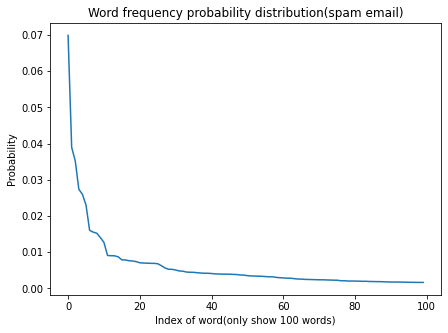

In [16]:
plt.figure(figsize = (7,5))
plt.plot(list(range(100)),y_spam)
plt.ylabel('Probability')
plt.xlabel('Index of word(only show 100 words)')
plt.title('Word frequency probability distribution(spam email)')
plt.show()

### Word frequency probability distribution(non-spam)

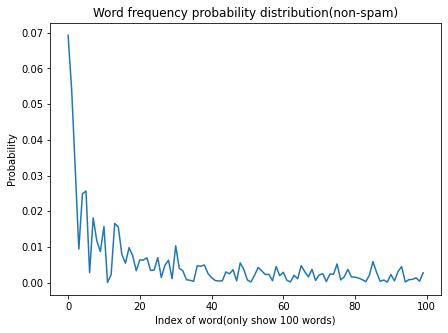

In [17]:
plt.figure(figsize = (7,5))
plt.plot(list(range(100)),y_ham)
plt.ylabel('Probability')
plt.xlabel('Index of word(only show 100 words)')
plt.title('Word frequency probability distribution(non-spam)')
plt.show()

In [18]:
#import training data
training = pd.read_csv('training.csv')
X_training = training.loc[:,'0':str(n-1)]
y_training = training.loc[:,[str(n)]]
y_training = np.array(y_training)
y_training = y_training[:,0]
X_training = np.concatenate( (np.ones((X_training.shape[0],1)),X_training), 1)


#import test data
test = pd.read_csv('test.csv')
X_test = test.loc[:,'0':str(n-1)]
y_test = test.loc[:,[str(n)]]
y_test = np.array(y_test)
y_test = y_test[:,0]
X_test = np.concatenate( (np.ones((X_test.shape[0],1)),X_test), 1)

In [19]:
training.shape

(2404, 1773)

In [20]:
test.shape

(602, 1773)

### Training and making prediction using the test set dataset

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
lr = LogisticRegression()
lr.fit(X_training, y_training)
lr_pred = lr.predict(X_test)

### Evaluation results for Logistic Regression model

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)

print('precision for Logistic Regression Model model is:', lr_precision)
print('recall for Logistic model is:',lr_rec)
print('F1-score for Logistic Regression is:',lr_f1)
print('Accuracy of correct prediction is:', lr_accuracy)

precision for Logistic Regression Model model is: 1.0
recall for Logistic model is: 0.9354838709677419
F1-score for Logistic Regression is: 0.9666666666666666
Accuracy of correct prediction is: 0.9900332225913622


### CREATING A JOBLIB FILE

In [24]:
import joblib
with open("Email_Classifier_Joblib.pkl", "wb") as file:
    joblib.dump(lr, file)